# Learning Outcomes
Image segmentation techniques:
1. k-means clustering
2. anisotropic segmentation (produce gradient structure tensor, followed by thresholding)
3. Watershed segmentation (marker - controlled)

# Setup


In [1]:
!pip install opencv-contrib-python

In [2]:
!pip install requests

In [3]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from util_func import *


## Simple demo of k-means clustering

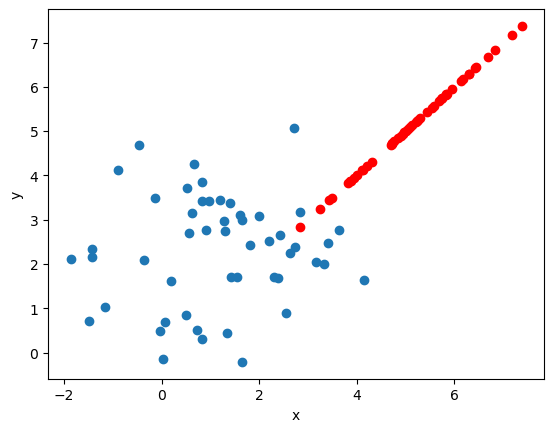

In [4]:
# create first cluster/batch of data
mean1 = (1, 2)
cov1 = np.array([[2, 0], [0, 1]])
dat1 = np.random.multivariate_normal(mean1, cov1, size = 50)

# create second cluster/batch of data
mean2 = (5, 6)
cov2 = np.array([[1, 0], [0, 2]])
dat2 = np.random.multivariate_normal(mean2, cov2, size = 50)

# concatenate
data = np.vstack((dat1, dat2))
Z = np.float32(data)

# visualize
plt.scatter(dat1[:, 0], dat1[:, 1])
plt.scatter(dat2[:, 0], dat2[:, 0], c = "r")
plt.xlabel("x"), plt.ylabel("y")
plt.show()


AttributeError: module 'matplotlib.pyplot' has no attribute 'tittle'

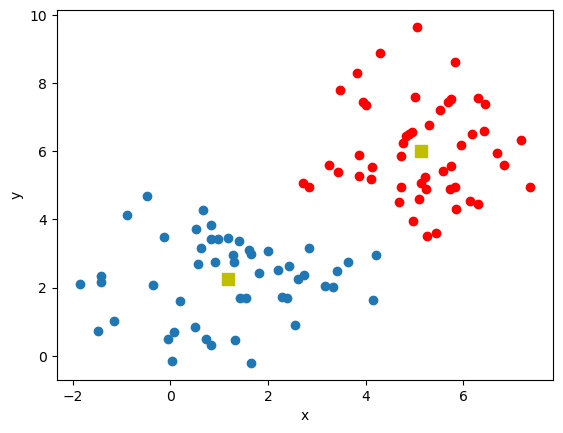

In [5]:
# k-means clustering
criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv.kmeans(Z, 2, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
#ret is WSOS

# subset the data into clusters defined
np.unique(label)
A = Z[label.flatten() == 0]
B = Z[label.flatten() == 1]

plt.scatter(A[:, 0], A[:, 1])
plt.scatter(B[:, 0], B[:, 1], c = "r")
plt.scatter(center[:, 0], center[:, 1], c = "y", marker = "s", s = 80)
plt.xlabel("x"), plt.ylabel("y")
plt.tittle("k-means clustering")
plt.show()


In [6]:
# apply k-means clustering on image
def k_means_clust(img, K, max_iter = 10, eps = 1.0, attempts = 10, flag = cv.KMEANS_PP_CENTERS):
    """Args:
    img: 3-channel color image
    K: user defined number of cluster
    By default, max_iter = 10, eps =1 , attempts = 10, k-means++"""
    # reshape and cast
    img = img.reshape((-1, 3))
    img = np.float32(img)
    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, max_iter, eps)
    return cv.kmeans(img, K, None, criteria, attempts, flag)


In [19]:
img = cv.imread("images/flower.jfif")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt_img(img_rgb, "flower")

NameError: name 'plt_img' is not defined

In [20]:
# call the function
ret, label, center = k_means_clust(img_rgb, 3)


In [21]:
# 
center = np.uint8(center)
res = center[label.ravel()]
quant = res.reshape(img_rgb.shape)

plt_img(quant, "k-means clustering")


NameError: name 'plt_img' is not defined

In [27]:
# LAB color space because of perceptual uniformity
img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)

ret, label, center = k_means_clust(img_lab, 3)

center = np.uint8(center)
res = center[label.ravel()]
quant = res.reshape(img_lab.shape)

quant_rgb = cv.cvtColor(quant, cv.COLOR_Lab2RGB)

plt_img(quant_rgb, "k-means (lab)")


NameError: name 'plt_img' is not defined

In [23]:
# interested to kno the distribution of cluster
np.unique(res, axis = 0, return_counts = True)


(array([[  2,   1,   2],
        [110, 107,  83],
        [210, 206, 204]], dtype=uint8),
 array([45372,  1915,  3038], dtype=int64))

In [30]:
# bar plot
centroids, counts = np.unique(res, axis = 0, return_counts = True)

# change the centroid to rgb
centroids = centroids.reshape((3, 1, 3))
centroids_rgb = cv.cvtColor(centroids, cv.COLOR_Lab2RGB)
centorids_rgb = centroids_rgb.reshape((3, 3))


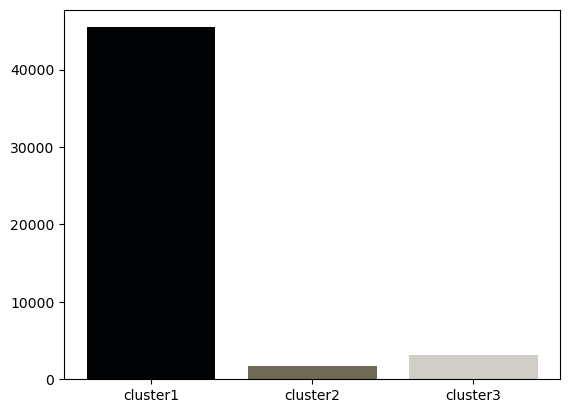

In [31]:
#
xlabel_name = ['cluster' + str(i) for i in range(1, 4)]

plt.bar(xlabel_name, counts, color = list(centroids_rgb / 255))

plt.show() 


## Anisotropic Segmentation


In [32]:
def calcGST(inputIMG, w, edge_method = "scharr"):
    img = np.float32(inputIMG)
    
    # Gradient structure tensor components
    if edge_method == "scharr":
        imgDiffX = cv.Scharr(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Scharr(img, cv.CV_32F, 0, 1)
    elif edge_method == "sobel":
        imgDiffXY = cv.sobel(imgDiffX, imgDiffY)
        imgDiffXX = cv.sobel(imgDiffX, imgDiffX)
    return
    imgDiffYY = cv.multiply(imgDiffY, imgDiffY)
    
    J11 = cv.boxFilter(imgDiffXX, cv.CV_32F, (w, w))
    J22 = cv.boxFilter(imgDiffYY, cv.CV_32F, (w, w))
    J12 = cv.boxFilter(imgDiffXY, cv.CV_32F, (w, w))
    
    # eigenvalue
    tmp1 = J11+J22
    tmp2 = J11-J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0*tmp3)
    
    lambda1 = 0.5*(tmp1+tmp4)
    lambda2 = 0.5*(tmp1 - tmp4)
    
    # coherency
    imgCoherencyOut = cv.divide(lambda1-lambda2, lambda1+lambda2)
    
    # orientation calculation
    imgOrientationOut = cv.phase(J22-J11, 2.0*J12, angleInDegrees = True)
    imgOrientationOut = 0.5*imgOrientationOut
    
    return imgCoherencyOut, imgOrientationOut


I had attempted Gaussian filtering, you will run into a numerical stability problem.
To remedy this problem, add a small constant on 'J22 - J11' on line 35. Line 17 - 19 is where you can iplement Gaussian filtering. 

In [35]:
# visualize coherency and orientation
img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img, (7, 7), 0)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

w = 25
imgCoherency, imgOrientation = calcGST(gray, w)

imgCoherency_norm = cv.normalize(imgCoherency, None, alpha = 0, beta = 1, norm_type = cv.NORM_MINMAX,
                                dtype = cv.CV_32F)
imgOrientation_norm = cv.normalize(imgOrientation, None, alpha = 0, beta = 1, norm_type = cv.NORM_MINMAX,
                                dtype = cv.CV_32F)

plt.subplot(121), plt_img(imgCoherency_norm, "Coherency")
plt.subplot(122), plt_img(imgOrientation_norm, "Orientation")
plt.show()


TypeError: cannot unpack non-iterable NoneType object

In [37]:
# trackbar
def nothing(x):
    pass

wn ="anisotropic segmentation"
cv.namedWindow(wn, cv.WINDOW_NORMAL | cv.WINDOW_FREERATIO)
cv.createTrackbar("Coherency threshold 1", wn, 50, 100, nothing)
cv.createTrackbar("Coherency threshold 2", wn, 70, 100, nothing)
cv.createTrackbar("Orientation threshold 1", wn, 50, 180, nothing)
cv.createTrackbar("Orientation threshold 2", wn, 100, 180, nothing)

img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img, (7, 7), 0)
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

w = 25
imgCoherency, imgOrientation = calcGST(gray, w)

while True:
    th_C_1 = cv.getTrackbarPos("Coherency threshold 1", wn) * 0.01
    th_C_2 = cv.getTrackbarPos("Coherency threshold 2", wn) * 0.01
    th_Or_1 = cv.getTrackbarPos("Orentation threshold 1", wn)
    th_Or_2 = cv.getTrackbarPos("Orentation threshold 2", wn)
    
    # perform thresholding
    imgBin_C_1 = cv.threshold(imgCoherency, th_C_1, 255, cv.THRESH_BINARY)[1]
    imgBin_C_2 = cv.threshold(imgCoherency, th_C_2, 255, cv.THRESH_BINARY_INV)[1]
    imgBin_Or_1 = cv.threshold(imgOrentation, th_Or_1, 255, cv.THRESH_BINARY)[1]
    imgBin_Or_2 = cv.threshold(imgOrentation, th_Or_2, 255, cv.THRESH_BINARY_INV)[1]
    
    imgBin_C = cv.bitwise_and(imgBin_C_1, imgBin_C_2)
    imgBin_Or = cv.bitwise_and(imgBin_Or_1, imgBin_Or_2)
    
    imgBin = cv.bitwise_and(imgBin_imgBin_Or)
    
    # mask, elementwise
    mask = imgBin != 0
    res = img * (mask[:, :, None].astype(np.uint8))
    cv.imshow(wn,res)
    cv.imshow('segmentation mask', imgBin)
    
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
        
cv.destroyAllWindows()


TypeError: cannot unpack non-iterable NoneType object

## Watershed Segmentation
Topographic surface: edge map

marker: morpological gradient + thresholding

In [38]:
from skimage.segmentation import watershed   # watershed
from scipy import ndimage as ndi   # conneced component labeling


In [39]:
img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img, (5, 5), 0)
# mean shift segmentation
blur = cv.pyrMeanShiftFiltering(blur, 15, 20, maxLevel = 2)

show_img("mean shift", blur)


In [43]:
# change grayscale
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

# morphological gradient (structuring element)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
loc_grad = cv.morphologyEx(gray, cv.MORPH_GRADIENT, kernel, iterations = 2)

show_img("gradient", loc_grad)


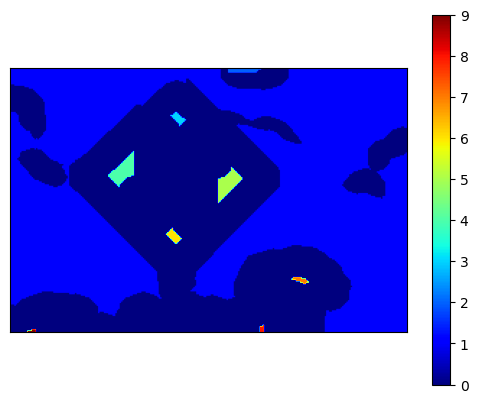

In [44]:
# thresholding
th = loc_grad < 80    # binary image
# connectivity
s = np.ones((3, 3), dtype = int)
marker = ndi.label(th, structure = s)[0]

plt.imshow(marker, cmap = plt.cm.jet)
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.show()


In [45]:
# topographic surface
edge = cv.Canny(gray, 250, 500)
labels = watershed(edge, marker)


In [46]:
np.unique(labels, return_counts = True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([40736,   279,  1234,  2325,  2295,  1270,  1066,   736,   384],
       dtype=int64))

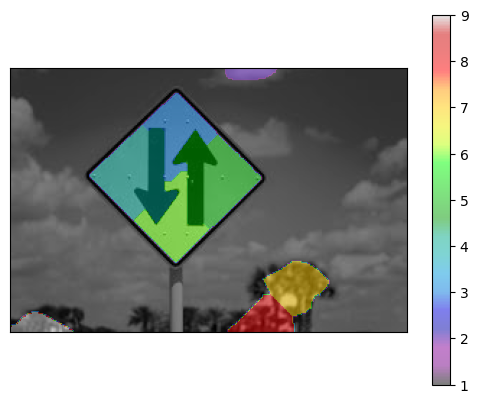

In [47]:
gray_ori = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(gray_ori, cmap = "gray")
plt.imshow(labels, cmap = plt.cm.nipy_spectral, alpha = .5)
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.show()


In [50]:
# create a white mask, suppress the pixel of background to 0, find contour
mask = 255 * np.ones(labels.shape, dtype = np.uint8)

# assumption: background has the largest area
label_vec, counts = np.unique(labels, return_counts = True)
label_bg = label_vec[np.argmax(counts)]

mask[labels == label_bg] = 0

# find contours
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# grab the largest area contour
contour = sorted(contours, key = cv.contourArea, reverse = True)[0]

img_copy = img.copy()
cv.drawContours(img_copy, [contour], -1, (0, 255, 0), 2)

show_img("contout", img_copy)


In [51]:
x, y, w, h = cv.boundingRect(contour)
img = cv.imread("images/traffic_sign.jfif")
cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
show_img("bounding box", img)


## Watershed Example
Topographic surface: -Distance Transform <br>
marker: thresholding + distance transform

In [52]:
# another traffic sign image
img = cv.imread("images/traffic_sign1.jpg")

show_img("img", img)


In [54]:
# blurring
blur = cv.GaussianBlur(img, (5, 5), 0)

# onvert to Lab
img_lab = cv.cvtColor(blur, cv.COLOR_BGR2Lab)

# k-means clustering
ret, label, center = k_means_clust(img_lab, 10)

# reshape
center = np.uint8(center)
res = center[label.flatten()]
quant = res.reshape(img_lab.shape)

quant_bgr = cv.cvtColor(quant, cv.COLOR_Lab2BGR)

show_img("k-means lab", quant_bgr)

In [57]:
# grayscale
gray = cv.cvtColor(quant_bgr, cv.COLOR_BGR2GRAY)

# otsu thresholding
th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

# morphological opening
kernel = np.ones((3, 3), dtype = np.uint8)
th = cv.morphologyEx(th, cv.MORPH_OPEN, kernel, iterations = 3)

show_img("th", th)


In [58]:
from skimage.feature import peak_local_max

In [59]:
# distance transform
dist_transform = cv.distanceTransform(th, cv.DIST_L2, 3)

# mask 
mask = np.zeros(dist_transform.shape, dtype = bool)
coords = peak_local_max(dist_transform, footprint = np.ones((100, 100)), labels = th)
mask[tuple(coords.T)] = True
marker = ndi.label(mask)[0]

# watershed
labels = watershed(-dist_transform, marker, mask = th)


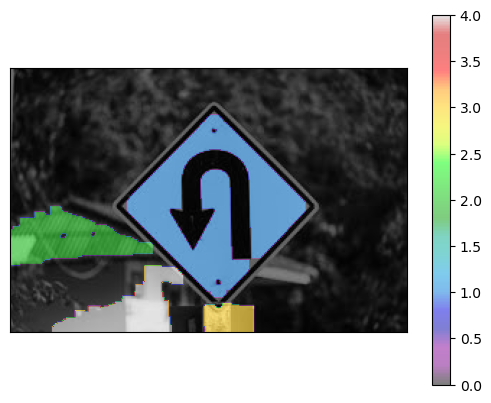

In [60]:
gray_ori = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(gray_ori, cmap = "gray")
plt.imshow(labels, cmap = plt.cm.nipy_spectral, alpha = .5)
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.show()

In [61]:
np.unique(labels, return_counts = True)

(array([0, 1, 2, 3, 4]),
 array([38899,  6431,  2363,   649,  1983], dtype=int64))

In [63]:
# create a white mask, suppress the pixel of background to 0, find contour
mask = 255 * np.ones(labels.shape, dtype = np.uint8)

# assumption: background has the largest area
label_vec, counts = np.unique(labels, return_counts = True)
label_bg = label_vec[np.argmax(counts)]

mask[labels == label_bg] = 0

# find contours
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# grab the largest area contour
contour = sorted(contours, key = cv.contourArea, reverse = True)[0]

img_copy = img.copy()
cv.drawContours(img_copy, [contour], -1, (0, 255, 0), 2)

show_img("contour", img_copy)

In [64]:
x, y, w, h = cv.boundingRect(contour)
img_copy = img.copy()
cv.rectangle(img_copy, (x, y), (x+w, y+h), (0,255,0), 2)
show_img("bounding box", img_copy)

### Exercise


In [65]:
# load image
img = cv.imread("images/zebra.jfif")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt_img(img_rgb, "zebra")

NameError: name 'plt_img' is not defined

In [ ]:
# array to store sum of squares
sum_of_squares = []

for k in range(2, 11):
    ret, label, center = k_means_clust(img_rgb, k)
    sum_of_squares.append(ret)
    
plt.plot(range(2, 11), sum_of_squares, marker="o")
plt.xlabel("no. of clusters")
plt.ylabel("WCSS")
plt.show()